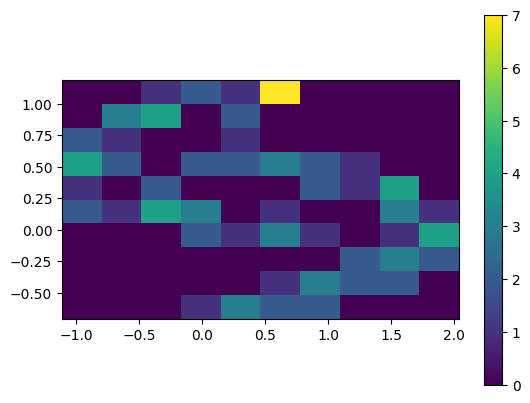

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate the data
X, _ = make_moons(n_samples=100, noise=0.1)

# Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=10)

# Visualize the histogram
plt.imshow(hist, interpolation='nearest', origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar()
plt.show()

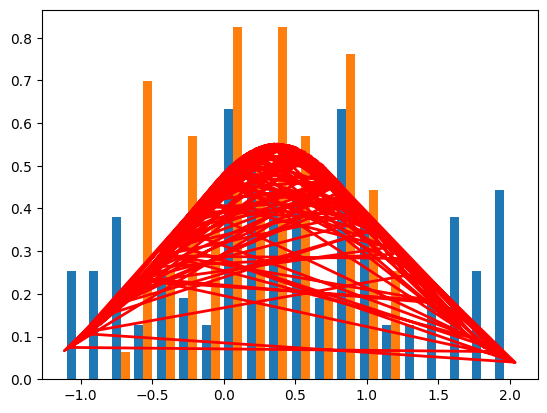

In [6]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Fit a Gaussian to the data
params = norm.fit(X)

# Create a PDF from the Gaussian parameters
pdf = norm.pdf(X, loc=params[0], scale=params[1])

# Visualize the data and the Gaussian distribution
plt.hist(X, bins=20, density=True)
plt.plot(X, pdf, 'r-', lw=2)
plt.show()

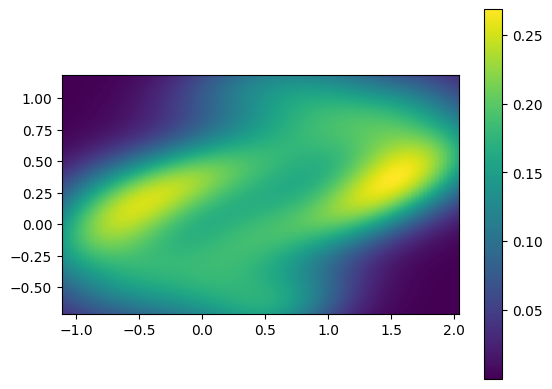

In [7]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Fit a KDE with squared exponential kernel to the data
kde = gaussian_kde(X.T, bw_method="silverman")

# Create a grid of points for visualization
x, y = np.mgrid[X[:,0].min():X[:,0].max():100j, X[:,1].min():X[:,1].max():100j]
positions = np.vstack([x.ravel(), y.ravel()])

# Evaluate the KDE on the grid
density = kde(positions)

# Visualize the KDE
plt.imshow(density.reshape(x.shape), extent=[X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()])
plt.colorbar()
plt.show()